# Load Data

In [1]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

r = urlopen("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zipfile = ZipFile(BytesIO(r.read()))

#print the content of zipfile
zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [2]:
import pandas as pd

ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'), usecols=["userId", "movieId", "rating"])
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [3]:
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df = movies_df.merge(ratings_df, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100854 entries, 0 to 100853
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100854 non-null  int64  
 1   title    100854 non-null  object 
 2   genres   100854 non-null  object 
 3   userId   100836 non-null  float64
 4   rating   100836 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.8+ MB


In [6]:
df.dropna(inplace=True)

In [7]:
num_samples = 1000#len(df)
df = df.sample(num_samples, random_state=42)
df.reset_index(drop=True, inplace=True)

In [8]:
df.rating.describe()

count    1000.000000
mean        3.536000
std         1.027014
min         0.500000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: rating, dtype: float64


# Prepare Dataset

In [9]:
# drop users that has less than min_num_ratings ratings
min_num_ratings = 5
df = df[df.groupby('userId').userId.transform('count')>min_num_ratings].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 0 to 995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  383 non-null    int64  
 1   title    383 non-null    object 
 2   genres   383 non-null    object 
 3   userId   383 non-null    float64
 4   rating   383 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.0+ KB


In [10]:
from math import ceil

df["rating"] = df.rating.replace(0.5, 1)
ratings = df.rating
ratins_round = []

for r in ratings:
    ratins_round.append(round(r))

In [11]:
df["rating"] = ratins_round

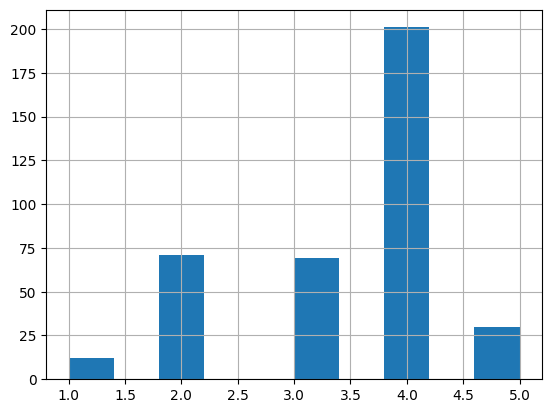

In [12]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
df.rating.hist()

plt.show()

In [13]:
unique_users = df.userId.unique().tolist()
len(unique_users)

38

In [14]:
unique_users_map = {}

for idx, mm in enumerate(df.userId.unique()):
    unique_users_map[int(mm)] = idx
len(unique_users_map)

38

In [15]:
movie_ids_map = {}

for idx, mm in enumerate(df.movieId.unique()):
    movie_ids_map[mm] = idx
len(movie_ids_map)

349

# Prepare Train Matrix

In [16]:
import numpy as np
import random
random.seed(42)
np.random.seed(42)

#X = np.ones((len(unique_users), len(movie_ids_map))) * 2.5
X = np.zeros((len(unique_users), len(movie_ids_map)))

nnz_coords = []
for row in df.itertuples():
    
    # given we have matrix, add in the actual ratings to the matrix
    x = unique_users_map[int(row.userId)]
    y = movie_ids_map[row.movieId]
    X[x, y] = row.rating
    
    # save the coordinates (row, column) of the ratings.
    nnz_coords.append((x,y))

In [17]:
from math import ceil
import scipy.sparse as ss

X_train = X.copy()
test_size = 0.1

num_nnz = len(nnz_coords)
num_test = ceil(num_nnz * test_size)
print(num_test)

removed_cords = random.sample(nnz_coords, num_test)

for x,y  in removed_cords:
    X_train[x, y] = 0

39


In [18]:
X_train = X_train.astype("float64")
X = X.astype("float64")
X_train_ss = ss.csr_matrix(X_train)

# RNMFk

In [19]:
from TELF.factorization import NMFk

params = {
    "n_perturbs":36,
    "n_iters":200,
    "epsilon":0.0015,
    "n_jobs":-3,
    "init":"nnsvd", 
    "use_gpu":False,
    "save_path":"../../results/", 
    "save_output":True,
    "collect_output":True,
    "predict_k":True,
    "predict_k_method":"sill",
    "verbose":True,
    "nmf_verbose":False,
    "transpose":False,
    "sill_thresh":0.9,
    "pruned":False,
    'nmf_method':'nmf_recommender', # nmf_fro_mu, nmf_recommender
    "joblib_backend":"multiprocessing",
    "calculate_error":True,
    "predict_k":True,
    "use_consensus_stopping":0,
    "calculate_pac":False,
    "perturb_type":"uniform",
}
Ks = range(1,21,1)
name = "RNMFk_Example"
note = "This is an example run of NMFk"

model = NMFk(**params)

Performing NMF with  nmf_recommender


/Users/maksim/opt/miniconda3/envs/TELF/lib/python3.8/site-packages/TELF-0.0.1-py3.8.egg/TELF/factorization/NMFk.py:500: UserWarning: calculate_error is True! Error calculation can make the runtime longer and take up more memory space!


In [20]:
results = model.fit(X_train_ss, Ks, name, note)

/Users/maksim/opt/miniconda3/envs/TELF/lib/python3.8/site-packages/TELF-0.0.1-py3.8.egg/TELF/factorization/NMFk.py:617: UserWarning: X is data type float64. Whic is not float32. Higher precision will result in significantly longer runtime!
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.


In [ ]:
results.keys()

dict_keys(['time', 'k_predict', 'W', 'H', 'other_results'])

In [ ]:
results["k_predict"]

6

# Define Prediction Helper

In [ ]:
W = results["W"]
H = results["H"]
global_mean = results["other_results"]["global_mean"]
bi = results["other_results"]["bi"]
bu = results["other_results"]["bu"]

predict = lambda W, H, global_mean, bu, bi, u, i: global_mean + bu[u] + bi[i] + np.dot(H[:, i], W[u])

In [ ]:
y_preds_test = []
y_trues_test = []
for u, i in removed_cords:
    y_preds_test.append(predict(W, H, global_mean, bu, bi, u, i))
    y_trues_test.append(X[u, i])
    
y_preds_test = np.array(y_preds_test)
y_trues_test = np.array(y_trues_test)

In [ ]:
rows, columns = X_train.nonzero()

y_preds_train = []
y_trues_train = []

for u, i in zip(rows, columns):
    y_preds_train.append(predict(W, H, global_mean, bu, bi, u, i))
    y_trues_train.append(X_train_ss[u, i])
    
y_preds_train = np.array(y_preds_train)
y_trues_train = np.array(y_trues_train)

In [ ]:
from sklearn.metrics import mean_squared_error

reconstruct = mean_squared_error(W@H, X_train, squared=True)
mse_train = mean_squared_error(y_preds_train, y_trues_train, squared=True)
mse_test = mean_squared_error(y_preds_test, y_trues_test, squared=True)

print("NMF reconstruction error:", reconstruct)
print("NMF train error:", mse_train)
print("NMF test error:", mse_test)

NMF reconstruction error: 0.25394917486505225
NMF train error: 0.6759924377525207
NMF test error: 0.8926493667555858
